In [64]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Step 1: Load and preprocess the dataset
file_path = "/kaggle/input/digit-recognizer/train.csv"  # Adjust to your file path

# Load the dataset
data = pd.read_csv(file_path)

# Separate features (pixel values) and labels (target values)
X = data.drop(columns=["label"]).values  # Drop the "label" column to get the features
y = data["label"].values  # Extract the "label" column as target labels

# Normalize the data by scaling the pixel values to [0, 1]
X = X / 255.0  # Normalize to range [0, 1]

# Reshape for compatibility with image dimensions (28x28)
X = X.reshape(-1, 1, 28, 28)


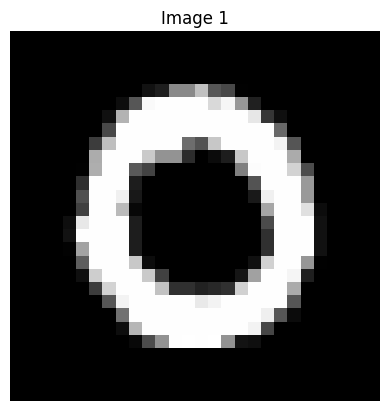

In [65]:

# Step 2: Visualize an example image
first_image = X[1]  # Assuming X is your feature matrix
plt.imshow(first_image[0], cmap="gray")
plt.title("Image 1")
plt.axis("off")
plt.show()


In [66]:

# Step 3: Define the Autoencoder Model with improvements
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder: Adding dropout and batch normalization for better generalization
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (1, 28, 28) -> (32, 14, 14)
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (32, 14, 14) -> (64, 7, 7)
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Flatten(),  # Flatten the output for fully connected layers
            nn.Linear(64*7*7, 128),  # Fully connected layer after flattening
            nn.ReLU(True),
            nn.Dropout(0.3)  # Dropout for regularization
        )

        # Decoder: Reconstructing the image from the encoded features
        self.decoder = nn.Sequential(
            nn.Linear(128, 64*7*7),  # Fully connected layer for decoding
            nn.ReLU(True),
            nn.BatchNorm1d(64*7*7),
            nn.Unflatten(1, (64, 7, 7)),  # Unflatten the vector back to 64 channels, 7x7 spatial size
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 7, 7) -> (32, 14, 14)
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32, 14, 14) -> (1, 28, 28)
            nn.Sigmoid()  # Sigmoid to scale pixel values between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)  # Encode the image
        decoded = self.decoder(encoded)  # Decode to reconstruct the image
        return decoded


In [67]:

# Step 4: Define the Dataset class
class MNISTDataset(Dataset):
    def __init__(self, features, labels=None, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx]
        image = torch.tensor(image, dtype=torch.float32)

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        return image


In [68]:

# Step 5: Prepare DataLoader
train_dataset = MNISTDataset(features=X, labels=y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [72]:
# Step 5.5: Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [76]:

# Step 6: Instantiate the model, criterion, and optimizer
model = Autoencoder().to(device)  # Move model to GPU (or CPU if no GPU available)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30


In [77]:

# Step 7: Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, _ in train_loader:  # We don't need labels for the autoencoder
        images = images.to(device)  # Move images to GPU (or CPU if no GPU available)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, images)  # MSE between original and reconstructed images

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()

        running_loss += loss.item()

    # Print loss every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")


Epoch [1/30], Loss: 0.05122736034577477
Epoch [2/30], Loss: 0.019136963935237224
Epoch [3/30], Loss: 0.016569331777388376
Epoch [4/30], Loss: 0.015146812965563262
Epoch [5/30], Loss: 0.014395251573889859
Epoch [6/30], Loss: 0.013742130856445028
Epoch [7/30], Loss: 0.013359120141153466
Epoch [8/30], Loss: 0.012985484263486877
Epoch [9/30], Loss: 0.012631137706509464
Epoch [10/30], Loss: 0.012318430710839082
Epoch [11/30], Loss: 0.012194544248441673
Epoch [12/30], Loss: 0.012035493312270312
Epoch [13/30], Loss: 0.011825629959345045
Epoch [14/30], Loss: 0.011650466501905585
Epoch [15/30], Loss: 0.011540255461120624
Epoch [16/30], Loss: 0.011396417801113888
Epoch [17/30], Loss: 0.01128166593339073
Epoch [18/30], Loss: 0.011131861094028165
Epoch [19/30], Loss: 0.011029393724031191
Epoch [20/30], Loss: 0.010934337589441822
Epoch [21/30], Loss: 0.010806768671914232
Epoch [22/30], Loss: 0.010714813345359975
Epoch [23/30], Loss: 0.010646018653234845
Epoch [24/30], Loss: 0.010535154457642063
Epo

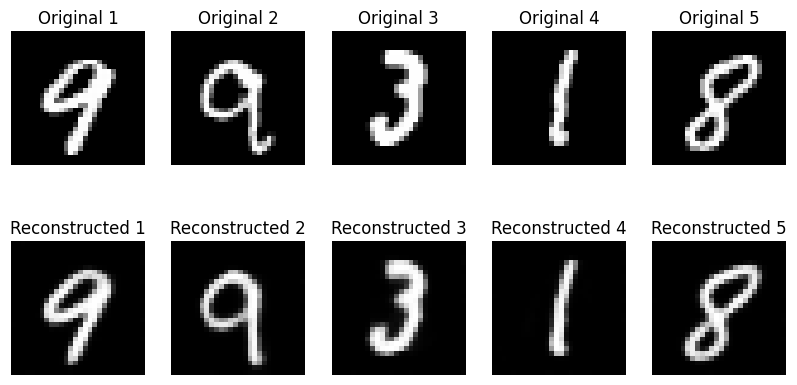

In [79]:

# Step 8: Visualize a few reconstructed images
model.eval()
with torch.no_grad():
    sample_data = next(iter(train_loader))[0].to(device)  # Get a batch of images and move to GPU
    outputs = model(sample_data)

    # Visualize original and reconstructed images
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i in range(5):
        ax = axes[0, i]
        ax.imshow(sample_data[i].view(28, 28).cpu(), cmap='gray')  # Move back to CPU for visualization
        ax.axis('off')
        ax.set_title(f"Original {i+1}")

        ax = axes[1, i]
        ax.imshow(outputs[i].view(28, 28).cpu(), cmap='gray')  # Move back to CPU for visualization
        ax.axis('off')
        ax.set_title(f"Reconstructed {i+1}")

    plt.show()